# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] I could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from my analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect("database.sqlite") 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final = pd.concat([final[final['Score']==1].sample(50000),final[final['Score']==0].sample(50000)],ignore_index=True)
final = final.sample(frac=1).reset_index(drop=True)
final['Score'].value_counts()

(364171, 10)


1    50000
0    50000
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that deduplication is finished for our data and requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

These pods are rather bland. I purchased them because I thought they would make a nice dessert coffee. They do not taste much different than regular coffee pods. I would not purchase them again, nor do I recommend them.
First off, I have to thank Amazon for getting this product to me.  My shipment got lost in the mail (sent via 2-day shipping), and Amazon overnighted me another shipment no questions asked.  The product itself is very good.  I use it mostly to sweeten green tea, and it has a very light flavor.  I tried it in my coffee, and it worked very well  I recommend this to anyone interested in a natural, healthier way to sweeten drinks or bake.
Sweet and Hot! These are so good I always eat too many and pay the price. You gotta try these! I put them on home made nachos. You know I think I may have to stop doing these reviews and have some.
The gum was in a nice red, white and blue bucket that contained 380 pieces, not just 360. A good value, and the flavor is just as you remember 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_4900)

The gum was in a nice red, white and blue bucket that contained 380 pieces, not just 360. A good value, and the flavor is just as you remember it from when you were a kid. Very highly recommended for us grown up bubble gum lovers.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

These pods are rather bland. I purchased them because I thought they would make a nice dessert coffee. They do not taste much different than regular coffee pods. I would not purchase them again, nor do I recommend them.
First off, I have to thank Amazon for getting this product to me.  My shipment got lost in the mail (sent via 2-day shipping), and Amazon overnighted me another shipment no questions asked.  The product itself is very good.  I use it mostly to sweeten green tea, and it has a very light flavor.  I tried it in my coffee, and it worked very well  I recommend this to anyone interested in a natural, healthier way to sweeten drinks or bake.
Sweet and Hot! These are so good I always eat too many and pay the price. You gotta try these! I put them on home made nachos. You know I think I may have to stop doing these reviews and have some.
The gum was in a nice red, white and blue bucket that contained 380 pieces, not just 360. A good value, and the flavor is just as you remember 

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Sweet and Hot! These are so good I always eat too many and pay the price. You gotta try these! I put them on home made nachos. You know I think I may have to stop doing these reviews and have some.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_1500 = re.sub("\S*\d\S*", "", sent_1500).strip()
print(sent_1500)

Sweet and Hot! These are so good I always eat too many and pay the price. You gotta try these! I put them on home made nachos. You know I think I may have to stop doing these reviews and have some.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

The gum was in a nice red white and blue bucket that contained 380 pieces not just 360 A good value and the flavor is just as you remember it from when you were a kid Very highly recommended for us grown up bubble gum lovers 


In [21]:
# https://gist.github.com/sebleier/554280
# removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, "br" is present in reviews
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above preprocessing steps 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:43<00:00, 2296.73it/s]


In [23]:
preprocessed_reviews[4900]

'gum nice red white blue bucket contained pieces not good value flavor remember kid highly recommended us grown bubble gum lovers'

## Splitting Data - Train(70%) & Test(30%)

Source: __https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6__
![](https://miro.medium.com/max/1420/1*-8_kogvwmL1H6ooN1A1tsQ.png)

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(preprocessed_reviews,final['Score'],test_size = 0.3, shuffle = False)

# [4] Featurization

## [4.1] BAG OF WORDS

Reference : 
1. __https://en.wikipedia.org/wiki/Bag-of-words_model#Example_implementation__
2. __http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html__

## [4.2] Bi-Grams and n-Grams.

Reference : __https://en.wikipedia.org/wiki/Bag-of-words_model#n-gram_model__

In [25]:
#bi-gram
#removing stop words like "not" should be avoided before building n-grams
#CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.preprocessing import StandardScaler 
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20)
standardizer = StandardScaler(with_mean=False)
bigrams_train = standardizer.fit_transform(count_vect.fit_transform(x_train))
bigrams_test = standardizer.transform(count_vect.transform(x_test))
print("some feature names ", count_vect.get_feature_names()[489:499])
print('='*50)

print("the type of count vectorizer ",type(bigrams_train))
print("the shape of out text BOW vectorizer for Train set ",bigrams_train.get_shape())
print("the number of unique words including both unigrams and bigrams in Train set ", bigrams_train.get_shape()[1])
print('='*50)                                             
print("the shape of out text BOW vectorizer for Test set ",bigrams_test.get_shape())
print("the number of unique words including both unigrams and bigrams Test set ", bigrams_test.get_shape()[1])                                              

some feature names  ['always order', 'always seem', 'always stock', 'always thought', 'always try', 'always trying', 'always use', 'always used', 'amaranth', 'amaretto']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for Train set  (70000, 19815)
the number of unique words including both unigrams and bigrams in Train set  19815
the shape of out text BOW vectorizer for Test set  (30000, 19815)
the number of unique words including both unigrams and bigrams Test set  19815


## [4.3] TF-IDF

Reference : 
1. __https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Definition__
2. __https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html__

In [26]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=20)
standardizer = StandardScaler(with_mean=False)
tfidf_bigrams_train = standardizer.fit_transform(tfidf_vect.fit_transform(x_train))
tfidf_bigrams_test = standardizer.transform(tfidf_vect.transform(x_test))
print("some feature names ", tfidf_vect.get_feature_names()[5000:5010])
print('='*50)

print("the type of count vectorizer ",type(tfidf_bigrams_train))
print("the shape of out text Tfidf vectorizer for Train set ",tfidf_bigrams_train.get_shape())
print("the number of unique words including both unigrams and bigrams in Train set ", tfidf_bigrams_train.get_shape()[1])
print('='*50)                                             
print("the shape of out text Tfidf vectorizer for Test set ",tfidf_bigrams_test.get_shape())
print("the number of unique words including both unigrams and bigrams Test set ", tfidf_bigrams_test.get_shape()[1]) 

some feature names  ['enjoyed much', 'enjoyed not', 'enjoyed product', 'enjoying', 'enjoyment', 'enjoys', 'enormous', 'enough', 'enough eat', 'enough flavor']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text Tfidf vectorizer for Train set  (70000, 19815)
the number of unique words including both unigrams and bigrams in Train set  19815
the shape of out text Tfidf vectorizer for Test set  (30000, 19815)
the number of unique words including both unigrams and bigrams Test set  19815


## [4.4] Word2Vec

In [27]:
# Train our own Word2Vec model using preprocessed reviews
sentancesListTrain=[]
for eachSentance in x_train:
    sentancesListTrain.append(eachSentance.split())
sentancesListTest=[]
for eachSentance in x_test:
    sentancesListTest.append(eachSentance.split())

Reference: 

1. __https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92__
2. __https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/__


![](https://miro.medium.com/max/1080/1*HmmFCZpKk3i4EvMYZ855tg.png)

In [28]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
w2v_model=Word2Vec(sentancesListTrain,min_count=5,size=100, workers=-1)
print(w2v_model.wv.most_similar('tasty'))
print('='*50)
print(w2v_model.wv.most_similar('horrible'))

[('favorably', 0.3707137703895569), ('accustomed', 0.36834192276000977), ('spirits', 0.3566123843193054), ('whisked', 0.3520267903804779), ('iodate', 0.3479880690574646), ('revv', 0.342900812625885), ('kipper', 0.34073328971862793), ('neutralize', 0.3350059688091278), ('jar', 0.3325083553791046), ('detectable', 0.33089423179626465)]
[('container', 0.4101524353027344), ('conducted', 0.33599990606307983), ('weight', 0.321274071931839), ('sceptical', 0.3180943727493286), ('scratching', 0.3171932101249695), ('untried', 0.3150271475315094), ('met', 0.31086596846580505), ('redi', 0.3090115487575531), ('convienient', 0.3039918541908264), ('satisfying', 0.30293363332748413)]


In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words : ", w2v_words[840:850])

number of words that occured minimum 5 times  16515
sample words :  ['completely', 'unacceptable', 'cruel', 'closer', 'shampoo', 'uses', 'espresso', 'machine', 'cocoa', 'powder']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [30]:
# average Word2Vec
# computing average word2vec for each review.
trainWord2Vectors = [] # the avg-w2v for each train sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTrain): 
    sentanceVector = np.zeros(100) # as word vectors are of zero length 50
    validWordCounts =0 # num of words with a valid vector in the sentence/review
    for eachWord in eachSentance: 
        if eachWord in w2v_words:
            vector = w2v_model.wv[eachWord]
            sentanceVector += vector
            validWordCounts += 1
    if validWordCounts != 0:
        sentanceVector /= validWordCounts
    trainWord2Vectors.append(sentanceVector)
    


100%|██████████| 70000/70000 [02:10<00:00, 537.18it/s]


In [31]:
standardizer = StandardScaler()
trainWord2Vectors = standardizer.fit_transform(trainWord2Vectors)
print(len(trainWord2Vectors))
print(len(trainWord2Vectors[0]))

70000
100


In [32]:
testWord2Vectors = []; # the avg-w2v for each test sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTest): 
    sentanceVector = np.zeros(100)
    validWordCounts =0
    for eachWord in eachSentance: 
        if eachWord in w2v_words:
            vector = w2v_model.wv[eachWord]
            sentanceVector += vector
            validWordCounts += 1
    if validWordCounts != 0:
        sentanceVector /= validWordCounts
    testWord2Vectors.append(sentanceVector)
    
testWord2Vectors = standardizer.transform(testWord2Vectors)
print(len(testWord2Vectors))
print(len(testWord2Vectors[0]))

100%|██████████| 30000/30000 [00:56<00:00, 532.56it/s]


30000
100


#### [4.4.1.2] TFIDF weighted W2v

In [33]:
tfidfW2VModel = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tfidfW2VModelVectors = tfidfW2VModel.fit_transform(x_train)
# creating hashmap with word as key and inverse document frequency as value
wordsHashMap = dict(zip(tfidfW2VModel.get_feature_names(), list(tfidfW2VModel.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidfWords = tfidfW2VModel.get_feature_names() # tfidf words

trainTfidfWord2Vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTrain): 
    sentanceVector = np.zeros(100) # as word vectors are of zero length
    weightedSum =0; # num of words with a valid vector in the sentence/review
    for eachWord in eachSentance: 
        if eachWord in w2v_words and eachWord in tfidfWords:
            vector = w2v_model.wv[eachWord]
            tf_idf = wordsHashMap[eachWord]*(eachSentance.count(eachWord)/len(eachSentance))
            sentanceVector += (vector * tf_idf)
            weightedSum += tf_idf
    if weightedSum != 0:
        sentanceVector /= weightedSum
    trainTfidfWord2Vectors.append(sentanceVector)
standardizer = StandardScaler()   
trainTfidfWord2Vectors = standardizer.fit_transform(trainTfidfWord2Vectors)
print(len(trainTfidfWord2Vectors))
print(len(trainTfidfWord2Vectors[0]))

100%|██████████| 70000/70000 [05:11<00:00, 224.53it/s]


70000
100


In [35]:
testTfidfWord2Vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTest): 
    sentanceVector = np.zeros(100) # as word vectors are of zero length
    weightedSum =0; # num of words with a valid vector in the sentence/review
    for eachWord in eachSentance: 
        if eachWord in w2v_words and eachWord in tfidfWords:
            vector = w2v_model.wv[eachWord]
            tf_idf = wordsHashMap[eachWord]*(eachSentance.count(eachWord)/len(eachSentance))
            sentanceVector += (vector * tf_idf)
            weightedSum += tf_idf
    if weightedSum != 0:
        sentanceVector /= weightedSum
    testTfidfWord2Vectors.append(sentanceVector)
    
testTfidfWord2Vectors = standardizer.transform(testTfidfWord2Vectors)
print(len(testTfidfWord2Vectors))
print(len(testTfidfWord2Vectors[0]))

100%|██████████| 30000/30000 [02:13<00:00, 225.51it/s]


30000
100


# K Nearest Neighbors

The ***k-nearest neighbors algorithm (k-NN)*** is a non-parametric method used for classification. In both cases, the input consists of the k closest training examples in the feature space. 

In ***k-NN classification***, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). k-NN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until function evaluation. The neighbors are taken from a set of objects for which the class (for k-NN classification) or the object property value (for k-NN regression) is known. This can be thought of as the training set for the algorithm, though no explicit training step is required. **A peculiarity of the k-NN algorithm is that it is sensitive to the local structure of the data.** 

### Algorithm
- The training examples are vectors in a multidimensional feature space, each with a class label. The training phase of the algorithm consists only of storing the feature vectors and class labels of the training samples.

- In the classification phase, k is a user-defined constant, and an unlabeled vector (a query or test point) is classified by assigning the label which is most frequent among the k training samples nearest to that query point.

- A commonly used distance metric **is Euclidean distance**. For discrete variables, such as for text classification, another metric can be used, such as the overlap metric (or Hamming distance). 

- A **drawback of the basic "majority voting"** classification occurs when the *class distribution is skewed*. That is, examples of a more frequent class tend to dominate the prediction of the new example, because they tend to be common among the k nearest neighbors due to their large number.[4] **One way to overcome this problem is to weight** the classification, taking into account the distance from the test point to each of its k nearest neighbors. The class (or value, in regression problems) of each of the k nearest points is multiplied by a weight proportional to the inverse of the distance from that point to the test point.

### Stastical Setting

Suppose we have pairs ${\displaystyle (X_{1},Y_{1}),(X_{2},Y_{2}),\dots ,(X_{n},Y_{n})}$ taking values in ${\displaystyle \mathbb {R} ^{d}\times \{1,2\}}$, where $Y$ is the class label of $X$, so that ${\displaystyle X|Y=r\sim P_{r}} X|Y=r\sim P_{r}$ for $r = 1 , 2$ (and probability distributions ${\displaystyle P_{r}}$). Given some norm ${\displaystyle \|\cdot \|}$ on ${\displaystyle \mathbb {R} ^{d}}$ and a point ${\displaystyle x\in \mathbb {R} ^{d}}$, let ${\displaystyle (X_{(1)},Y_{(1)}),\dots ,(X_{(n)},Y_{(n)})}$ be a reordering of the training data such that ${\displaystyle \|X_{(1)}-x\|\leq \dots \leq \|X_{(n)}-x\|} $


<div align="right"><font size=2>Source: Wikipedia</div>

In [36]:
#source - 
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
def gridSearcher(model,parameters,inputs,outputs):
    clf = GridSearchCV(model,
                       param_grid = parameters,
                       return_train_score = True,
                       scoring='roc_auc',
                       verbose = 10,
                       cv=5)
    clf.fit(inputs,outputs)
    return clf

In [37]:
#https://stackoverflow.com/a/42712772/12901493
import seaborn as sns
def plotAUCvsHyperParam(model):
    plt.figure(figsize=(10,10))
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
    
    testScore = model.cv_results_["mean_test_score"]
    testScore = testScore.reshape(len(model.param_grid["n_neighbors"]),len(model.param_grid["weights"]))
    g1 = sns.heatmap(testScore, 
                     annot = True,
                     fmt=".4f",
                     ax = ax1,
                     cmap = sns.color_palette("Paired"),
                     xticklabels=model.param_grid["weights"],
                     yticklabels=np.round(model.param_grid["n_neighbors"], 3))
    g1.set_xlabel("weights") 
    g1.set_ylabel("n_neighbors")
    title = "Best Cross Validation Score = "+\
            str(model.best_score_)+"\n"\
            " at "+\
            "n_neighbors "+str(model.best_params_["n_neighbors"])+\
            " , "+\
            "weights "+str(model.best_params_["weights"])
    ax1.title.set_text(title)
    ax1.title.set_fontsize(15)
    
    trainScore = model.cv_results_["mean_train_score"]
    trainScore = trainScore.reshape(len(model.param_grid["n_neighbors"]),len(model.param_grid["weights"]))
    indices = np.unravel_index(np.argmax(trainScore, axis=None), trainScore.shape)
    g2 = sns.heatmap(trainScore, 
                     annot = True,
                     fmt=".4f",
                     ax = ax2,
                     cmap = sns.color_palette("Paired"),
                     xticklabels=model.param_grid["weights"],
                     yticklabels=np.round(model.param_grid["n_neighbors"], 3))
    g2.set_xlabel("weights")
    g2.set_ylabel("n_neighbors")
    title = "Best Train Score = "+\
            str(trainScore.max())+"\n"\
            " at "+\
            "n_neighbors "+str(model.param_grid["n_neighbors"][indices[0]])+\
            " , "+\
            "weights "+str(model.param_grid["weights"][indices[1]])
    ax2.title.set_text(title)
    ax2.title.set_fontsize(15)

In [38]:
#source - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
from sklearn import metrics
def rocCurve(model,trainData,trainLabels,testData,testLabels):
    predictedProbabilities = model.predict_proba(testData)
    fpr, tpr, thresholds = metrics.roc_curve(testLabels, predictedProbabilities[:,1])
    plt.plot(fpr,tpr,label='Test AUC is %0.3f' %(metrics.auc(fpr,tpr)))
    predictedProbabilities = model.predict_proba(trainData)
    fpr, tpr, thresholds = metrics.roc_curve(trainLabels, predictedProbabilities[:,1])
    plt.plot(fpr,tpr,label='Train AUC is %0.3f' %(metrics.auc(fpr,tpr)))
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [39]:
#source - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix
def confusionMatrix(model,testData,testLabels):
    tn, fp, fn, tp = confusion_matrix(testLabels,model.predict(testData)).ravel()
    sns.heatmap([[tn,fp],[fn,tp]],yticklabels=["Actual 0","Actual 1"],\
                 xticklabels=["Predicted 0","Predicted 1"],annot = True,fmt='d')

# Applying K Nearest Neighbors

## [5.1] Applying Brute Force KNN on BOW

In [40]:
from sklearn.neighbors import KNeighborsClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
knn_bigram_model = gridSearcher(KNeighborsClassifier(n_jobs=-1),
                                   {"n_neighbors":[3,5,7,9,11],"weights":['uniform', 'distance']},
                                   bigrams_train,
                                   y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=(train=0.896, test=0.666), total=  16.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.916, test=0.686), total=  15.7s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.912, test=0.679), total=  15.7s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.912, test=0.676), total=  15.8s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed:  5.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.911, test=0.668), total=  15.9s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.685), total=  15.7s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed:  7.9min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.702), total=  15.8s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed:  9.2min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.699), total=  15.9s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed: 10.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.692), total=  15.8s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed: 11.9min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.688), total=  16.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.851, test=0.651), total=  22.6s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.856, test=0.663), total=  22.8s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.852, test=0.665), total=  21.4s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.852, test=0.653), total=  22.5s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.853, test=0.653), total=  19.2s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=(train=1.000, test

[Parallel(n_jobs=None)]: Done  50 out of  50 | elapsed: 85.8min finished


Text(0.49, 1, 'Bag of Words - Bigram')

<Figure size 720x720 with 0 Axes>

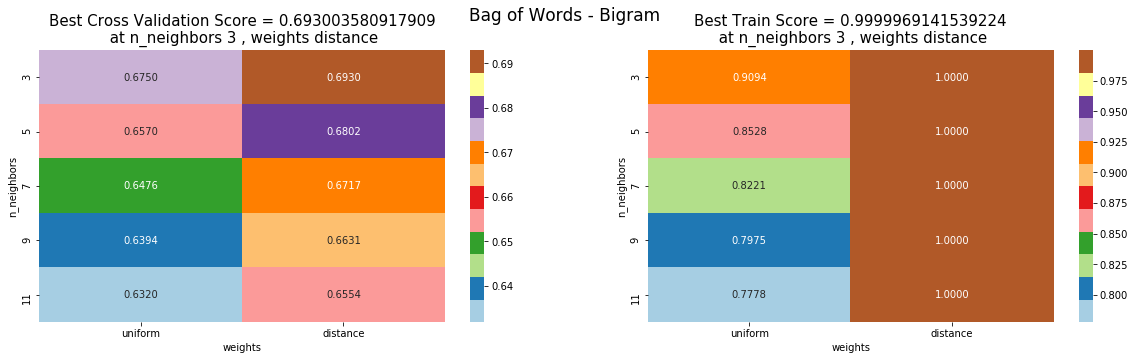

In [41]:
plotAUCvsHyperParam(knn_bigram_model)
plt.suptitle('Bag of Words - Bigram',fontsize=17,x=0.49,y = 1)

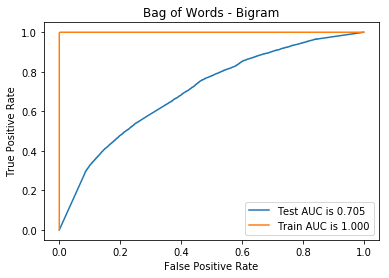

In [42]:
plt.title("Bag of Words - Bigram")
rocCurve(knn_bigram_model,bigrams_train,y_train,bigrams_test,y_test)

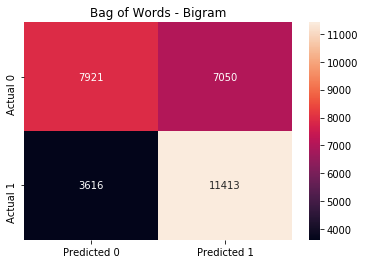

In [43]:
plt.title("Bag of Words - Bigram")
confusionMatrix(knn_bigram_model,bigrams_test,y_test)

## [5.2] Applying Brute Force KNN on TFIDF

In [44]:
knn_tfidf_bigram_model = gridSearcher(KNeighborsClassifier(n_jobs=-1),
                                   {"n_neighbors":[3,5,7,9,11],"weights":['uniform', 'distance']},
                                         tfidf_bigrams_train,
                                         y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=(train=0.971, test=0.536), total=  15.8s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.976, test=0.534), total=  15.7s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.977, test=0.533), total=  16.3s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.977, test=0.529), total=  15.9s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed:  5.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.977, test=0.529), total=  16.0s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.548), total=  15.9s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed:  8.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.554), total=  16.0s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed:  9.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.551), total=  15.8s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed: 10.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.548), total=  16.0s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed: 12.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.549), total=  15.9s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.763, test=0.517), total=  22.7s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.763, test=0.523), total=  23.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.775, test=0.526), total=  17.4s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.767, test=0.514), total=  22.6s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.770, test=0.514), total=  16.9s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=(train=0.999, test

[Parallel(n_jobs=None)]: Done  50 out of  50 | elapsed: 82.0min finished


Text(0.49, 1, 'Tfidf - Bigram')

<Figure size 720x720 with 0 Axes>

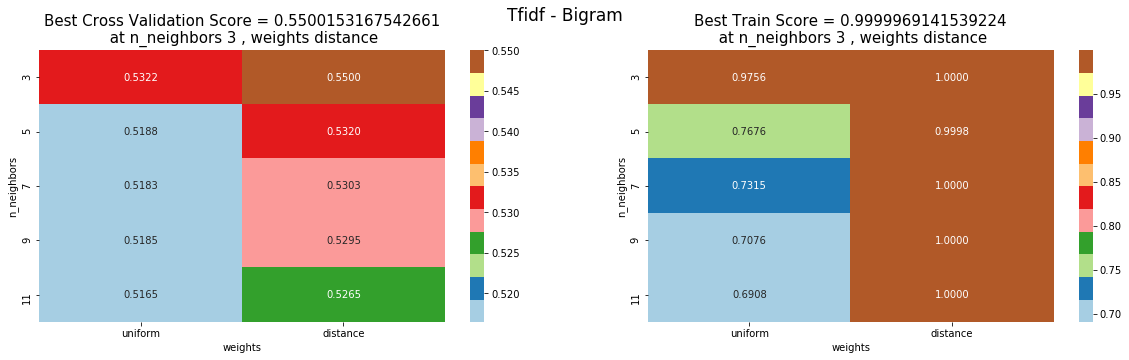

In [45]:
plotAUCvsHyperParam(knn_tfidf_bigram_model)
plt.suptitle('Tfidf - Bigram',fontsize=17,x=0.49,y = 1)

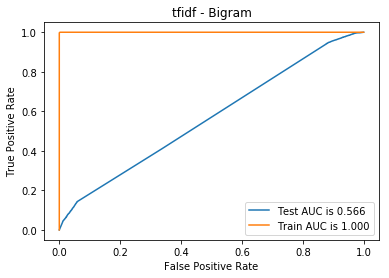

In [46]:
plt.title("tfidf - Bigram")
rocCurve(knn_tfidf_bigram_model,tfidf_bigrams_train,y_train,tfidf_bigrams_test,y_test)

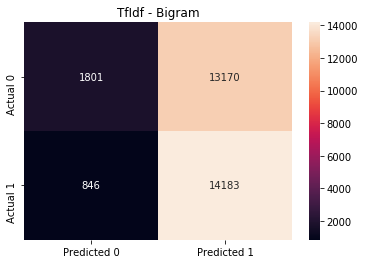

In [47]:
plt.title("TfIdf - Bigram")
confusionMatrix(knn_tfidf_bigram_model,tfidf_bigrams_test,y_test)

## [5.3] Applying Brute Force KNN on Average Word2VEC

In [48]:
knn_avgW2v_model = gridSearcher(KNeighborsClassifier(n_jobs=-1),
                                   {"n_neighbors":[3,5,7,9,11],"weights":['uniform', 'distance']},
                                   trainWord2Vectors,
                                   y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=(train=0.867, test=0.620), total=  30.4s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.870, test=0.621), total=  38.0s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.867, test=0.622), total=  35.7s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:  8.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.866, test=0.626), total=  35.7s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed: 11.5min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.866, test=0.619), total=  35.7s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed: 14.5min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.626), total=  35.7s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed: 17.4min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.628), total=  21.4s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed: 19.2min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.629), total=  40.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed: 22.5min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=0.999, test=0.632), total=  20.4s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed: 24.2min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=0.999, test=0.625), total=  20.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.827, test=0.639), total=  20.4s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.827, test=0.640), total=  39.7s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.826, test=0.637), total=  39.7s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.822, test=0.644), total=  39.7s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.825, test=0.639), total=  39.7s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=(train=1.000, test

[Parallel(n_jobs=None)]: Done  50 out of  50 | elapsed: 131.1min finished


Text(0.49, 1, 'Average Word2Vec')

<Figure size 720x720 with 0 Axes>

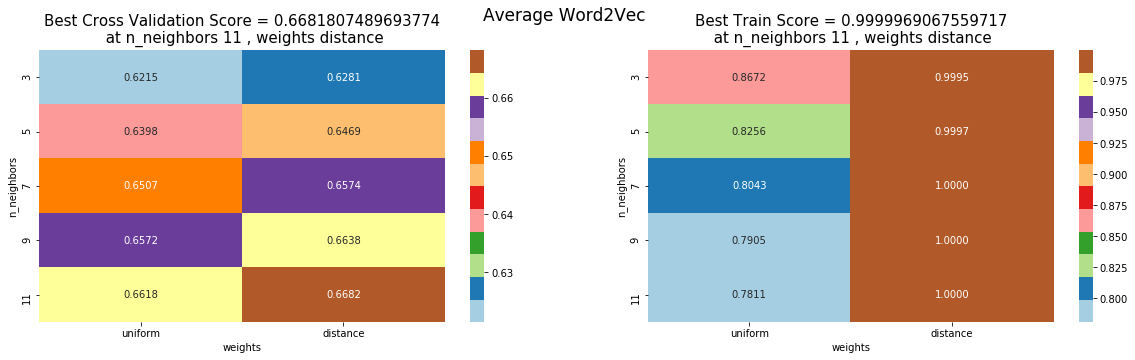

In [49]:
plotAUCvsHyperParam(knn_avgW2v_model)
plt.suptitle('Average Word2Vec',fontsize=17,x=0.49,y = 1)

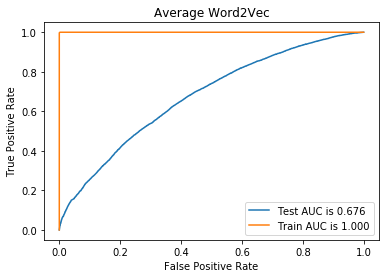

In [50]:
plt.title("Average Word2Vec")
rocCurve(knn_avgW2v_model,trainWord2Vectors,y_train,testWord2Vectors,y_test)

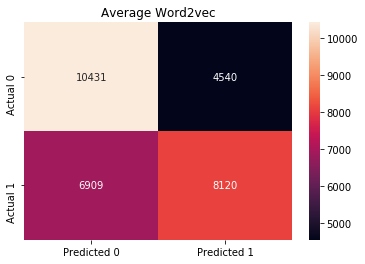

In [51]:
plt.title("Average Word2vec")
confusionMatrix(knn_avgW2v_model,testWord2Vectors,y_test)

## [5.4] Applying Brute Force KNN on TFIDF Weighted W2V

In [52]:
knn_tfidfW2v_model = gridSearcher(KNeighborsClassifier(n_jobs=-1),
                                   {"n_neighbors":[3,5,7,9,11],"weights":['uniform', 'distance']},
                                     trainTfidfWord2Vectors,
                                     y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=(train=0.868, test=0.624), total=  37.2s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.872, test=0.620), total=  34.5s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:  5.9min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.871, test=0.617), total=  34.5s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:  8.8min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.874, test=0.631), total=  36.2s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed: 11.8min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.873, test=0.622), total=  36.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed: 14.8min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=0.999, test=0.631), total=  36.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed: 17.8min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=0.999, test=0.626), total=  37.5s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed: 20.8min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.625), total=  34.5s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed: 23.7min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.636), total=  36.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed: 26.7min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.629), total=  36.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.820, test=0.638), total=  36.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.825, test=0.633), total=  25.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.823, test=0.635), total=  36.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.826, test=0.643), total=  37.6s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.830, test=0.634), total=  36.4s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=(train=0.999, test

[Parallel(n_jobs=None)]: Done  50 out of  50 | elapsed: 145.9min finished


Text(0.49, 1, 'Tfidf Weighted Word2Vec')

<Figure size 720x720 with 0 Axes>

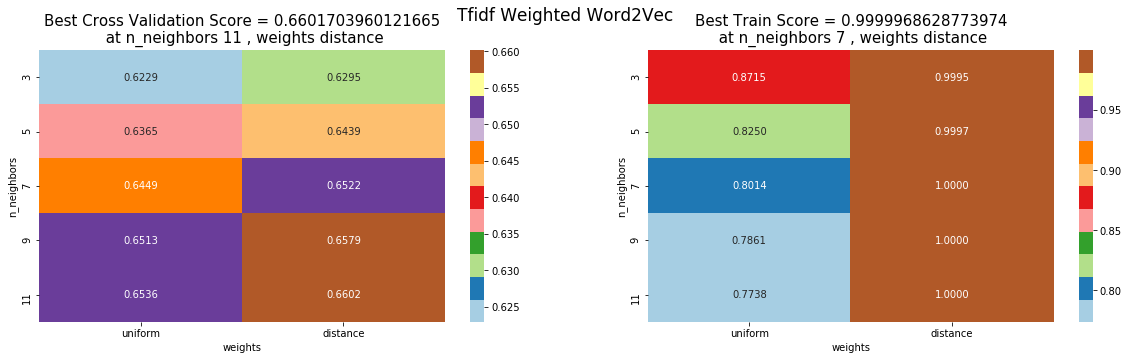

In [53]:
plotAUCvsHyperParam(knn_tfidfW2v_model)
plt.suptitle('Tfidf Weighted Word2Vec',fontsize=17,x=0.49,y = 1)

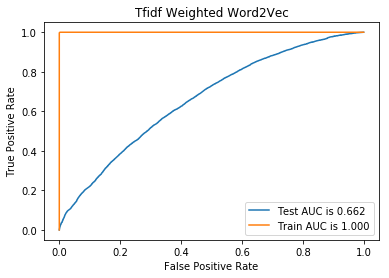

In [54]:
plt.title("Tfidf Weighted Word2Vec")
rocCurve(knn_tfidfW2v_model,trainTfidfWord2Vectors,y_train,testTfidfWord2Vectors,y_test)

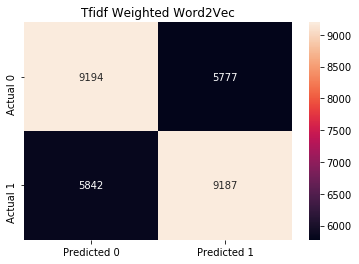

In [55]:
plt.title("Tfidf Weighted Word2Vec")
confusionMatrix(knn_tfidfW2v_model,testTfidfWord2Vectors,y_test)

In [56]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectoriser","parameters","Train AUC Score","Test AUC score"]
table.add_row(["KNN(BOW)",
               knn_bigram_model.best_params_,
               np.round(knn_bigram_model.score(bigrams_train,y_train),5),
               np.round(knn_bigram_model.score(bigrams_test,y_test),5)])
table.add_row(["KNN(TFIDF)",
               knn_tfidf_bigram_model.best_params_,
               np.round(knn_tfidf_bigram_model.score(tfidf_bigrams_train,y_train),5),
               np.round(knn_tfidf_bigram_model.score(tfidf_bigrams_test,y_test),5)])
table.add_row(["KNN(Avg W2V)",
               knn_avgW2v_model.best_params_,
               np.round(knn_avgW2v_model.score(trainWord2Vectors,y_train),5),
               np.round(knn_avgW2v_model.score(testWord2Vectors,y_test),5)])
table.add_row(["KNN(TFIDF W2V)",
               knn_tfidfW2v_model.best_params_,
               np.round(knn_tfidfW2v_model.score(trainTfidfWord2Vectors,y_train),5),
               np.round(knn_tfidfW2v_model.score(testTfidfWord2Vectors,y_test),5)])

In [57]:
from sklearn.preprocessing import StandardScaler 
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20, max_features=500)
standardizer = StandardScaler(with_mean=False)
bigrams_train = standardizer.fit_transform(count_vect.fit_transform(x_train))
bigrams_test = standardizer.transform(count_vect.transform(x_test))
print("some feature names ", count_vect.get_feature_names()[489:499])
print('='*50)

print("the type of count vectorizer ",type(bigrams_train))
print("the shape of out text BOW vectorizer for Train set ",bigrams_train.get_shape())
print("the number of unique words including both unigrams and bigrams in Train set ", bigrams_train.get_shape()[1])
print('='*50)                                             
print("the shape of out text BOW vectorizer for Test set ",bigrams_test.get_shape())
print("the number of unique words including both unigrams and bigrams Test set ", bigrams_test.get_shape()[1])                                              

some feature names  ['work', 'works', 'worst', 'worth', 'would', 'would not', 'wrong', 'year', 'years', 'yes']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for Train set  (70000, 500)
the number of unique words including both unigrams and bigrams in Train set  500
the shape of out text BOW vectorizer for Test set  (30000, 500)
the number of unique words including both unigrams and bigrams Test set  500


In [58]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=20, max_features=500)
standardizer = StandardScaler(with_mean=False)
tfidf_bigrams_train = standardizer.fit_transform(tfidf_vect.fit_transform(x_train))
tfidf_bigrams_test = standardizer.transform(tfidf_vect.transform(x_test))
print("some feature names ", tfidf_vect.get_feature_names()[300:310])
print('='*50)

print("the type of count vectorizer ",type(tfidf_bigrams_train))
print("the shape of out text Tfidf vectorizer for Train set ",tfidf_bigrams_train.get_shape())
print("the number of unique words including both unigrams and bigrams in Train set ", tfidf_bigrams_train.get_shape()[1])
print('='*50)                                             
print("the shape of out text Tfidf vectorizer for Test set ",tfidf_bigrams_test.get_shape())
print("the number of unique words including both unigrams and bigrams Test set ", tfidf_bigrams_test.get_shape()[1]) 

some feature names  ['nuts', 'oil', 'ok', 'old', 'one', 'ones', 'online', 'open', 'opened', 'orange']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text Tfidf vectorizer for Train set  (70000, 500)
the number of unique words including both unigrams and bigrams in Train set  500
the shape of out text Tfidf vectorizer for Test set  (30000, 500)
the number of unique words including both unigrams and bigrams Test set  500


# [6] Applying Kd-Tree KNN

## [6.1] Applying Kd-Tree KNN on Bigram BOW

In [59]:
kdtree_bigram_model = gridSearcher(KNeighborsClassifier(n_jobs=-1,algorithm='kd_tree'),
                                   {"n_neighbors":[3,5,7,9,11],"weights":['uniform', 'distance']},
                                bigrams_train[:20000].toarray(),
                                y_train[:20000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=(train=0.908, test=0.722), total=   6.2s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:   25.8s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.909, test=0.707), total=   6.2s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:   51.5s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.904, test=0.732), total=   6.2s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.906, test=0.714), total=   6.2s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.909, test=0.702), total=   6.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.729), total=   6.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.712), total=   6.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed:  3.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.745), total=   6.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed:  3.4min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.721), total=   6.2s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed:  3.9min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.705), total=   6.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.882, test=0.752), total=   6.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.882, test=0.736), total=   6.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.879, test=0.756), total=   6.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.879, test=0.738), total=   6.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.886, test=0.724), total=   6.2s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=(train=1.000, test

[Parallel(n_jobs=None)]: Done  50 out of  50 | elapsed: 21.6min finished


Text(0.49, 1, 'Bag of Words - Bigram')

<Figure size 720x720 with 0 Axes>

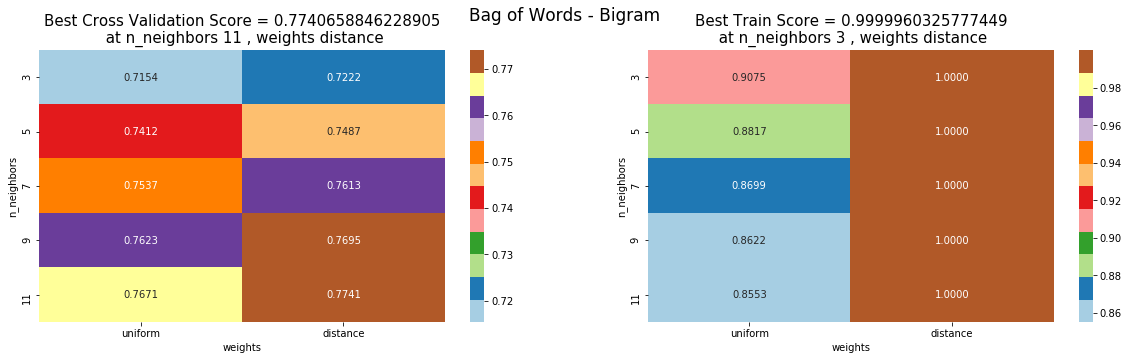

In [60]:
plotAUCvsHyperParam(kdtree_bigram_model)
plt.suptitle('Bag of Words - Bigram',fontsize=17,x=0.49,y = 1)

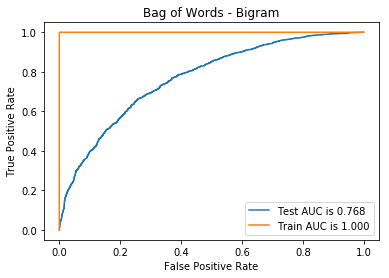

In [61]:
plt.title("Bag of Words - Bigram")
rocCurve(kdtree_bigram_model,bigrams_train[:20000].toarray(),y_train[:20000],bigrams_test[:5000].toarray(),y_test[:5000])

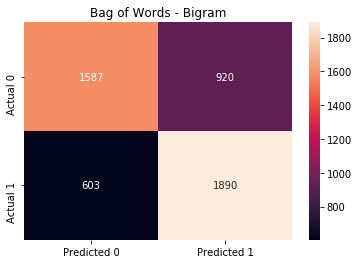

In [62]:
plt.title("Bag of Words - Bigram")
confusionMatrix(kdtree_bigram_model,bigrams_test[:5000].toarray(),y_test[:5000])

## [6.2] Applying Kd-Tree Knn on Bigram Tfidf

In [63]:
kdtree_tfidf_bigram_model = gridSearcher(KNeighborsClassifier(n_jobs=-1,algorithm='kd_tree'),
                                   {"n_neighbors":[3,5,7,9,11],"weights":['uniform', 'distance']},
                                      tfidf_bigrams_train[:20000].toarray(),
                                      y_train[:20000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=(train=0.911, test=0.600), total=   6.4s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:   26.8s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.905, test=0.601), total=  10.9s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.881, test=0.607), total=   9.7s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.871, test=0.591), total=   9.8s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed:  2.7min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.883, test=0.603), total=   9.8s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed:  3.4min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.626), total=   9.5s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed:  4.1min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.619), total=   9.5s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed:  4.8min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.624), total=   6.6s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed:  5.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.603), total=   7.6s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed:  5.8min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.624), total=   7.5s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.886, test=0.601), total=  10.1s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.847, test=0.601), total=  10.9s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.846, test=0.601), total=   9.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.823, test=0.584), total=  10.8s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.845, test=0.608), total=   5.2s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=(train=1.000, test

[Parallel(n_jobs=None)]: Done  50 out of  50 | elapsed: 35.9min finished


Text(0.49, 1, 'Tfidf - Bigram')

<Figure size 720x720 with 0 Axes>

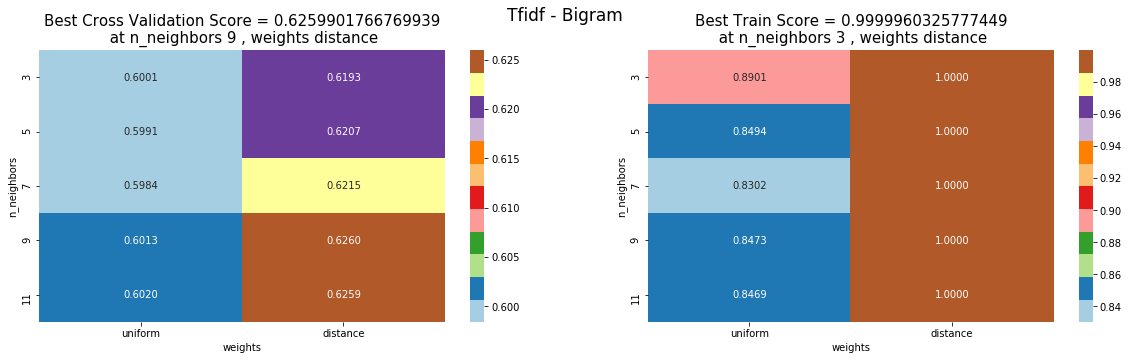

In [64]:
plotAUCvsHyperParam(kdtree_tfidf_bigram_model)
plt.suptitle('Tfidf - Bigram',fontsize=17,x=0.49,y = 1)

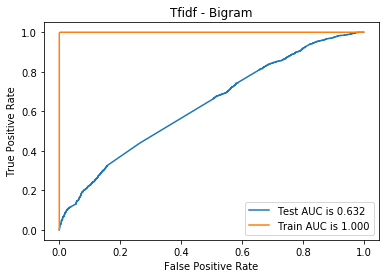

In [65]:
plt.title("Tfidf - Bigram")
rocCurve(kdtree_tfidf_bigram_model,tfidf_bigrams_train[:20000].toarray(),y_train[:20000],tfidf_bigrams_test[:5000].toarray(),y_test[:5000])

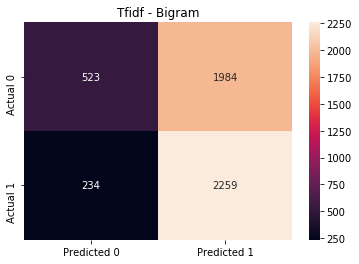

In [66]:
plt.title("Tfidf - Bigram")
confusionMatrix(kdtree_tfidf_bigram_model,tfidf_bigrams_test[:5000].toarray(),y_test[:5000])

## [6.3] Applying Kd-Tree KNN on Average Word2VEC

In [67]:
kdtree_avgW2v_model = gridSearcher(KNeighborsClassifier(n_jobs=-1,algorithm='kd_tree'),
                                   {"n_neighbors":[3,5,7,9,11],"weights":['uniform', 'distance']},
                                trainWord2Vectors[:20000],
                                y_train[:20000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=(train=0.859, test=0.594), total=   3.5s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.854, test=0.612), total=   3.5s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:   33.9s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.859, test=0.592), total=   1.8s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:   42.5s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.858, test=0.594), total=   1.8s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed:   51.1s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.867, test=0.610), total=   1.8s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed:   59.7s remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.604), total=   3.4s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.617), total=   4.4s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.598), total=   2.8s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.599), total=   1.8s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.615), total=   1.8s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.821, test=0.618), total=   1.9s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.814, test=0.628), total=   1.9s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.820, test=0.612), total=   1.8s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.810, test=0.611), total=   1.8s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.826, test=0.622), total=   1.8s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=(train=1.000, test

[Parallel(n_jobs=None)]: Done  50 out of  50 | elapsed: 13.8min finished


Text(0.49, 1, 'Average Word2Vec - Bigram')

<Figure size 720x720 with 0 Axes>

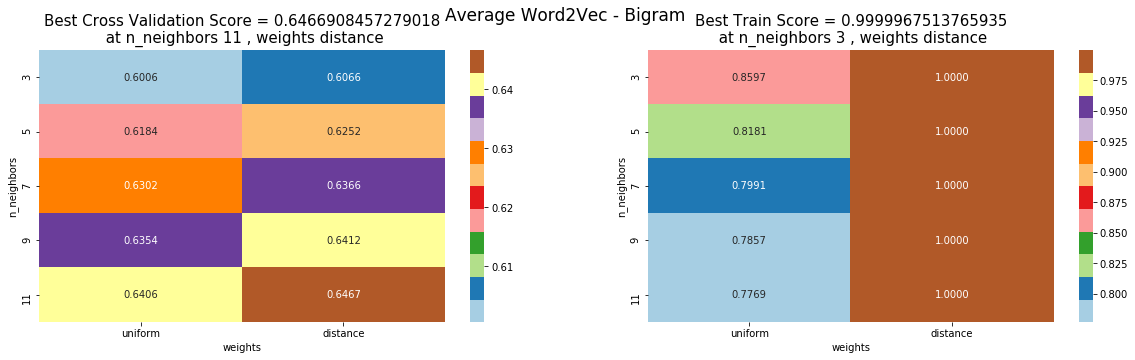

In [68]:
plotAUCvsHyperParam(kdtree_avgW2v_model)
plt.suptitle('Average Word2Vec - Bigram',fontsize=17,x=0.49,y = 1)

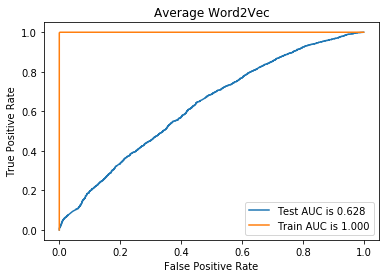

In [69]:
plt.title("Average Word2Vec")
rocCurve(kdtree_avgW2v_model,trainWord2Vectors[:20000],y_train[:20000],testWord2Vectors[:5000],y_test[:5000])

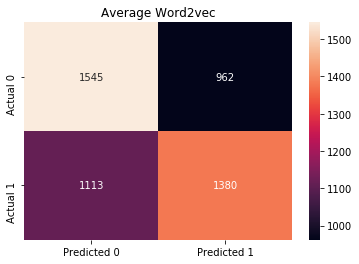

In [70]:
plt.title("Average Word2vec")
confusionMatrix(kdtree_avgW2v_model,testWord2Vectors[:5000],y_test[:5000])

## [6.4] Applying Kd-Tree KNN on TFIDF Weighted W2V

In [71]:
kdtree_tfidfW2v_model = gridSearcher(KNeighborsClassifier(n_jobs=-1,algorithm='kd_tree'),
                                   {"n_neighbors":[3,5,7,9,11],"weights":['uniform', 'distance']},
                                  trainTfidfWord2Vectors[:20000],
                                  y_train[:20000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=(train=0.843, test=0.604), total=   2.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.854, test=0.598), total=   2.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:   19.4s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.849, test=0.587), total=   2.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:   29.2s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.864, test=0.592), total=   2.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed:   38.9s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.860, test=0.608), total=   2.1s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed:   48.6s remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.612), total=   2.1s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed:   58.3s remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.604), total=   2.1s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.589), total=   2.1s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.596), total=   2.1s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=(train=0.999, test=0.614), total=   3.5s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.800, test=0.612), total=   2.1s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.810, test=0.608), total=   4.1s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.799, test=0.600), total=   4.1s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.809, test=0.600), total=   4.1s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=(train=0.823, test=0.608), total=   2.1s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=(train=1.000, test

[Parallel(n_jobs=None)]: Done  50 out of  50 | elapsed: 12.5min finished


Text(0.49, 1, 'Tfidf Weighted Word2Vec')

<Figure size 720x720 with 0 Axes>

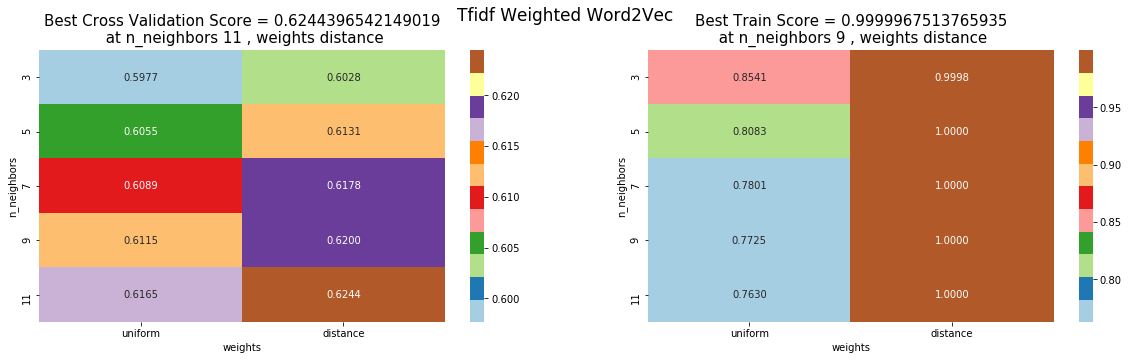

In [72]:
plotAUCvsHyperParam(kdtree_tfidfW2v_model)
plt.suptitle('Tfidf Weighted Word2Vec',fontsize=17,x=0.49,y = 1)

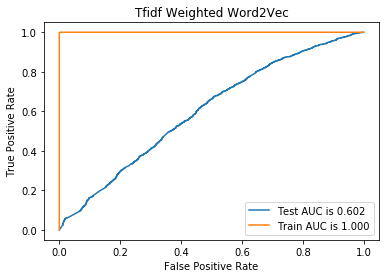

In [73]:
plt.title("Tfidf Weighted Word2Vec")
rocCurve(kdtree_tfidfW2v_model,trainTfidfWord2Vectors[:20000],y_train[:20000],testTfidfWord2Vectors[:5000],y_test[:5000])

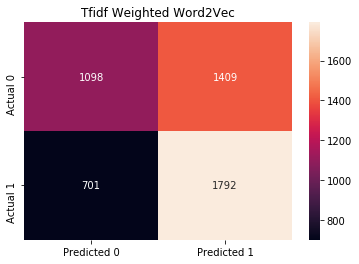

In [74]:
plt.title("Tfidf Weighted Word2Vec")
confusionMatrix(kdtree_tfidfW2v_model,testTfidfWord2Vectors[:5000],y_test[:5000])

In [75]:
table.add_row(["Kd-Tree(BOW)",
               kdtree_bigram_model.best_params_,
               np.round(kdtree_bigram_model.score(bigrams_train[:20000].toarray(),y_train[:20000]),5),
               np.round(kdtree_bigram_model.score(bigrams_test[:5000].toarray(),y_test[:5000]),5)])
table.add_row(["Kd-Tree(TFIDF)",
               kdtree_tfidf_bigram_model.best_params_,
               np.round(kdtree_tfidf_bigram_model.score(tfidf_bigrams_train[:20000].toarray(),y_train[:20000]),5),
               np.round(kdtree_tfidf_bigram_model.score(tfidf_bigrams_test[:5000].toarray(),y_test[:5000]),5)])
table.add_row(["Kd-Tree(Avg W2V)",
               kdtree_avgW2v_model.best_params_,
               np.round(kdtree_avgW2v_model.score(trainWord2Vectors[:20000],y_train[:20000]),5),
               np.round(kdtree_avgW2v_model.score(testWord2Vectors[:5000],y_test[:5000]),5)])
table.add_row(["Kd-Tree(TFIDF W2V)",
               kdtree_tfidfW2v_model.best_params_,
               np.round(kdtree_tfidfW2v_model.score(trainTfidfWord2Vectors[:20000],y_train[:20000]),5),
               np.round(kdtree_tfidfW2v_model.score(testTfidfWord2Vectors[:5000],y_test[:5000]),5)])

# [7] Conclusions

In [76]:
print(table)

+--------------------+--------------------------------------------+-----------------+----------------+
|     Vectoriser     |                 parameters                 | Train AUC Score | Test AUC score |
+--------------------+--------------------------------------------+-----------------+----------------+
|      KNN(BOW)      | {'n_neighbors': 3, 'weights': 'distance'}  |       1.0       |    0.70501     |
|     KNN(TFIDF)     | {'n_neighbors': 3, 'weights': 'distance'}  |       1.0       |    0.56626     |
|    KNN(Avg W2V)    | {'n_neighbors': 11, 'weights': 'distance'} |       1.0       |    0.67566     |
|   KNN(TFIDF W2V)   | {'n_neighbors': 11, 'weights': 'distance'} |       1.0       |    0.66222     |
|    Kd-Tree(BOW)    | {'n_neighbors': 11, 'weights': 'distance'} |       1.0       |    0.76839     |
|   Kd-Tree(TFIDF)   | {'n_neighbors': 9, 'weights': 'distance'}  |       1.0       |    0.63169     |
|  Kd-Tree(Avg W2V)  | {'n_neighbors': 11, 'weights': 'distance'} |      